In [65]:
import numpy as np
from scipy import ndimage
from skimage import measure

def power_spectrum(image):
    return np.abs(np.fft.fftshift(np.fft.fft2(image - np.mean(image)))) ** 2


def ellipse_metrics(pattern):
    power = power_spectrum(pattern)
    smoothed_power = ndimage.gaussian_filter(power, 4)
    # smoothed_power = power
    return smoothed_power


def extract_features(power, thresholds=[0.5, 0.75]):
    power_total = np.sum(power)
    sorted_power = np.sort(power.T.flatten())[::-1]

    cum_power = np.cumsum(sorted_power) / power_total
    
    metrics = []
    for i, threshold in enumerate(thresholds):
        power_threshold = sorted_power[np.argmax(cum_power > threshold)]
        mask = power >= power_threshold
        props = measure.regionprops_table(mask.astype(int), 
                                          properties=('centroid', 
                                                      'major_axis_length', 
                                                      'minor_axis_length', 
                                                      'orientation'))
        
        plt.figure()
        plt.imshow(mask)
        plt.show()
        
        metrics.append(props)
    return metrics

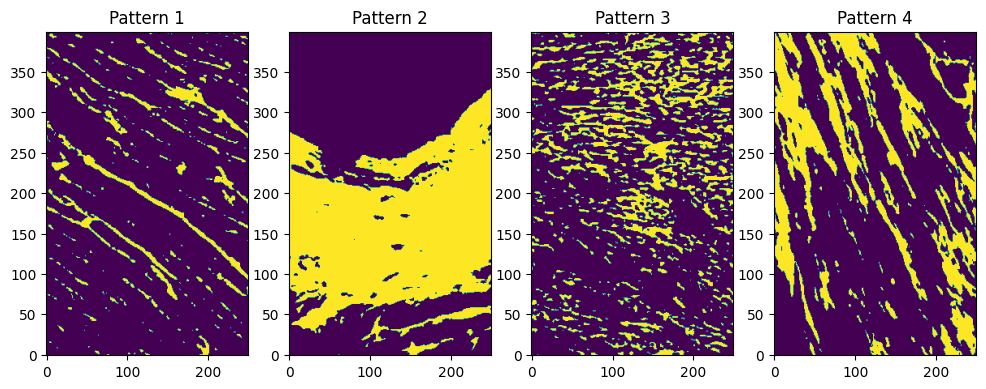

In [43]:
from pathlib import Path
from scipy import io
import matplotlib.pyplot as plt


path = Path('/Users/arstanbek/Projects/perlin-microfibrosis')

data = io.loadmat(path.joinpath('histo_patterns.mat'))

images = []

fig, axs = plt.subplots(ncols=4, figsize=(12, 5))
for i, im in enumerate(data['patterns'][0]):
    im = im[:, :]
    axs[i].imshow(im, origin='lower')
    axs[i].set_title(f'Pattern {i+1}')
    images.append(im)
    # axs[i].axis('off')
plt.show()

In [33]:
from bitis.texture.properties import (
    DistributionEllipseBuilder,
    PolarPlots,
    PatternPropertiesBuilder
)


def swap_axis(angle):
    """
    Swap axis for polar plot.
    """
    return 0.5 * np.pi - angle


def draw_anisotropy(ax, image, n_std=2):

    pattern_builder = PatternPropertiesBuilder(area_quantile=0.95)
    pattern_builder.build(image == 2)
    objects_props = pattern_builder.object_props
    
    objects_props = objects_props[objects_props['area'] >= 5]
    r = objects_props['axis_ratio'].values
    theta = objects_props['orientation'].values

    r = np.concatenate([r, r])
    theta = np.concatenate([theta, theta + np.pi])

    theta = swap_axis(theta)

    dist_ellipse_builder = DistributionEllipseBuilder()
    dist_ellipse = dist_ellipse_builder.build(r, theta, n_std=n_std)
    full_theta = dist_ellipse.full_theta
    orientation = dist_ellipse.orientation
    r, theta, d = PolarPlots.sort_by_density(r, theta)

    ax.scatter(theta, r, c=d, s=30, alpha=1, cmap='viridis')
    ax.plot(full_theta, dist_ellipse.full_radius, color='red')

    ax.quiver(0, 0, orientation, 0.5 * dist_ellipse.width,
              angles='xy', scale_units='xy', scale=1, color='red')
    ax.quiver(0, 0, 0.5 * np.pi + orientation,
              0.5 * dist_ellipse.height,
              angles='xy', scale_units='xy', scale=1, color='red')

In [56]:
from fibrosisanalysis.parsers import ImageLoader


path = Path('/Users/arstanbek/Projects/BiTis/data/simulated_adaptive')

images_or = []
for i in range(1, 5):
    image = ImageLoader().load_slice_data(path.joinpath(f'gen_tex_{i}_0.png'))
    images_or.append(image)

In [78]:
template = im[50:80, 50:80]
%timeit signal.fftconvolve(im, template, mode='valid')
%timeit signal.oaconvolve(im, template, mode='valid')


221 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
237 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [82]:
def calc_distance_map(image, template):
    """Calculate the distance map between the training image and
    the template.

    Args:
        image (numpy.ndarray): The training image.
        template (numpy.ndarray): The template.
    """
    dist_fibr = signal.correlate((image == 2).astype(float),
                                    (template == 2).astype(float),
                                    mode='valid', method='fft')
    dist_myo = signal.correlate((image == 1).astype(float),
                                (template == 1).astype(float),
                                mode='valid', method='fft')
    dist = dist_fibr + dist_myo
    return dist / (template > 0).sum()

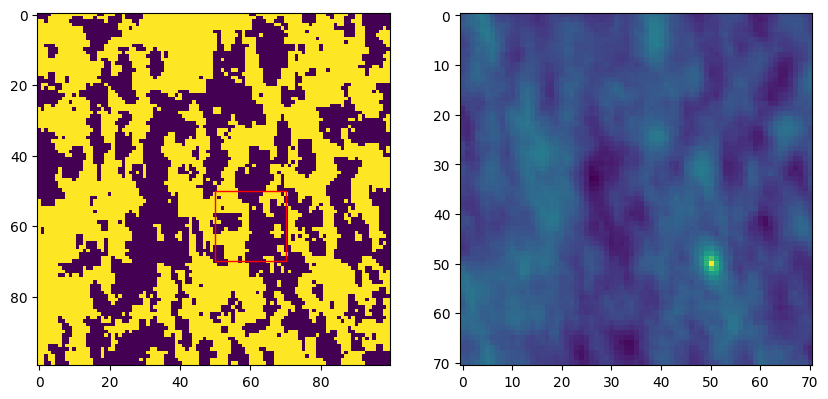

In [83]:
from scipy import signal

im = images_or[0]
template = im[50:80, 50:80]

res = calc_distance_map(im, template)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(im)
axs[0].add_patch(plt.Rectangle((50, 50), 20, 20, edgecolor='red', facecolor='none'))
axs[1].imshow(res)
plt.show()

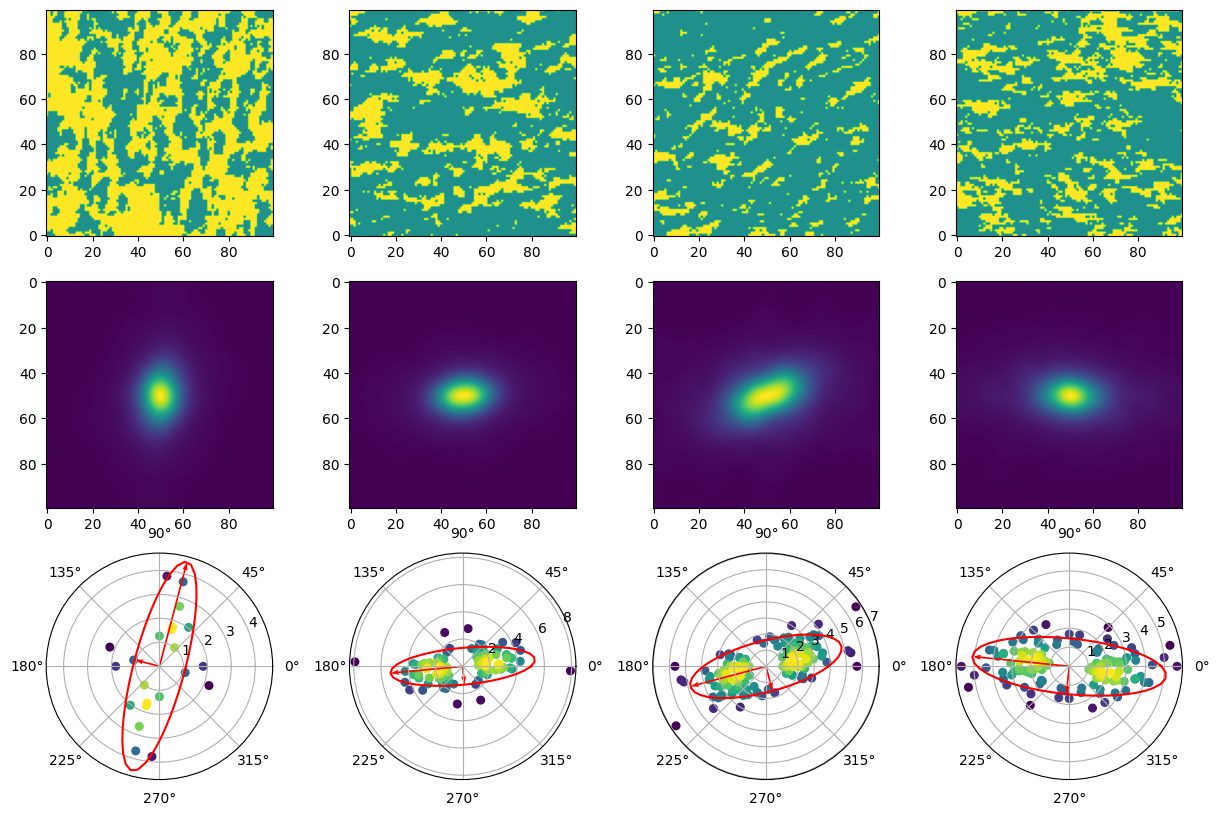

In [66]:

fig, axs = plt.subplot_mosaic([['image1', 'image2', 'image3', 'image4'],
                                ['power1', 'power2', 'power3', 'power4'],
                                ['anisotropy1', 'anisotropy2', 'anisotropy3', 'anisotropy4']],
                                figsize=(15, 10),
                                per_subplot_kw={'anisotropy1': {'projection': 'polar'},
                                                  'anisotropy2': {'projection': 'polar'},
                                                  'anisotropy3': {'projection': 'polar'},
                                                  'anisotropy4': {'projection': 'polar'}})

for i, im in enumerate(images_or):
    ps = ellipse_metrics((im > 1).astype(float))
    # print(extract_features(ps, [0.5]))
    axs[f'image{i+1}'].imshow(im, origin='lower', vmin=0, vmax=2)
    axs[f'power{i+1}'].imshow(ps.T)
    draw_anisotropy(axs[f'anisotropy{i+1}'], im)
plt.show()

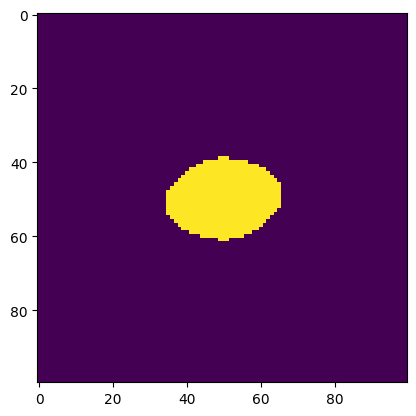

[{'centroid-0': array([50.]), 'centroid-1': array([50.]), 'major_axis_length': array([31.13267375]), 'minor_axis_length': array([21.65925564]), 'orientation': array([-1.45012581])}]


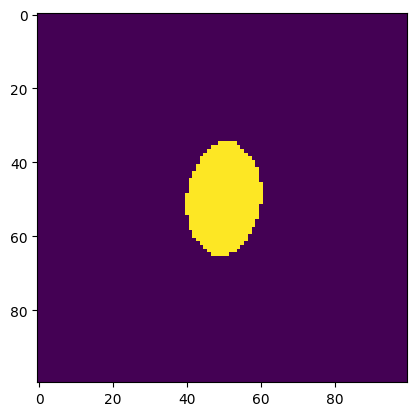

[{'centroid-0': array([50.]), 'centroid-1': array([50.]), 'major_axis_length': array([30.75744051]), 'minor_axis_length': array([20.17704942]), 'orientation': array([-0.11188692])}]


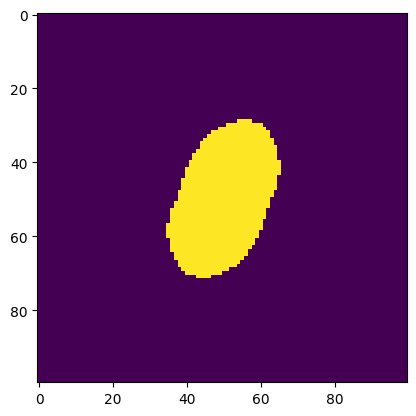

[{'centroid-0': array([50.]), 'centroid-1': array([50.]), 'major_axis_length': array([45.67192126]), 'minor_axis_length': array([25.56746528]), 'orientation': array([-0.39294081])}]


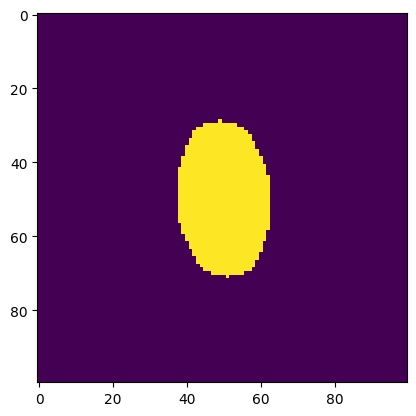

[{'centroid-0': array([50.]), 'centroid-1': array([50.]), 'major_axis_length': array([42.69184746]), 'minor_axis_length': array([25.39420445]), 'orientation': array([0.07008835])}]


In [68]:
for im in images_or:
    ps = ellipse_metrics((im > 1).astype(float))
    print(extract_features(ps, [0.5]))

In [ ]:
import matplotlib.pyplot as plt

from sklearn.covariance import EmpiricalCovariance, MinCovDet

X = ps.T > 
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print("MCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    )
)

In [44]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


from bitis.tissue_models.direct_sampling.simulations import TextureAdaptiveSimulation


def generate_image(training_image):
    simulation_image = np.zeros(training_image.shape, dtype=np.float64)
    simulation = TextureAdaptiveSimulation(training_image,
                                           simulation_image,
                                           max_size=30,
                                           max_distance=10,
                                           min_distance=10)
    simulation.run()
    return simulation_image


training_images = []
for training_image in images:
    training_image = 1 + training_image
    training_images.append(training_image)

simulated_images = Parallel(n_jobs=4)(delayed(generate_image)(training_images[i]) for i in range(4))
    # simulated_images.append(generate_image(training_image))


100%|██████████| 62500/62500 [09:28<00:00, 110.00it/s]


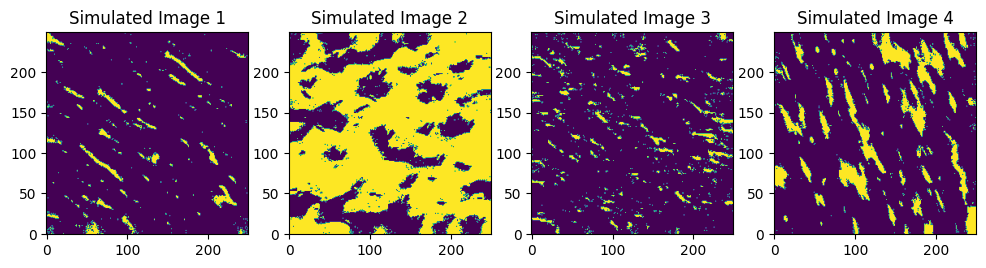

In [45]:
fig, axs = plt.subplots(ncols=4, figsize=(12, 5))

for i, im in enumerate(simulated_images):
    axs[i].imshow(im, origin='lower')
    axs[i].set_title(f'Simulated Image {i+1}')
plt.show()